In [1]:
import numpy as np 
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt 
from numba import njit

In [2]:
np.random.seed(1234)

n_samples = 2000 # ieri la porta seriale è morta dopo circa 2600 samples, oggi dopo 2218; meglio giocarsela in modo safe

#frequenze = range()

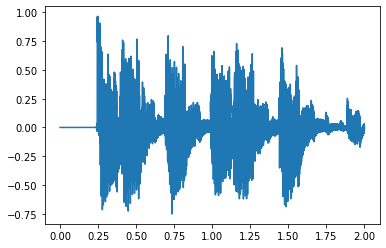

In [2]:
M = np.loadtxt("mario.txt", delimiter=",")
t = M[:,0]
x = M[:,1]
plt.plot(t,x);

In [5]:
np.nonzero(x > 0.25)

(array([ 2693,  2694,  2695, ..., 17309, 17311, 20825], dtype=int64),)

In [9]:
t[2693]

0.244185519336265

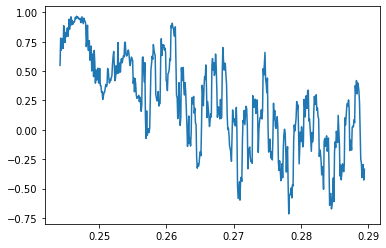

In [4]:
n_samples = 500 #700 #2000 # NIENTE, DEVO SCENDERE A 700... # FACCIAMO 500!

indice_tempo_inizio_parte_interessante = 2693
i = indice_tempo_inizio_parte_interessante
x2 = x[i:i+n_samples]
t2 = t[i:i+n_samples]
plt.plot(t2,x2);

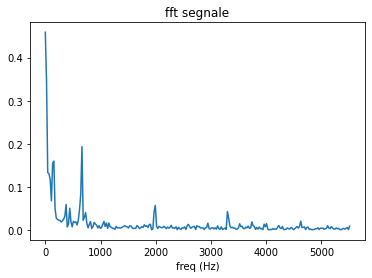

In [193]:
a = np.abs(np.fft.fft(x2))
a = a[0:len(a)//2]*2/a.shape[0]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale");

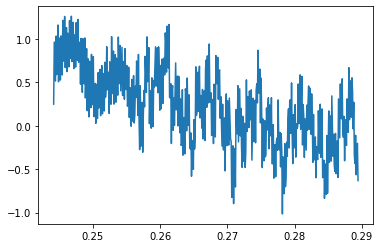

In [5]:
xc = x2 + 0.3*np.sin(2*np.pi*4000*t2)
plt.plot(t2,xc);

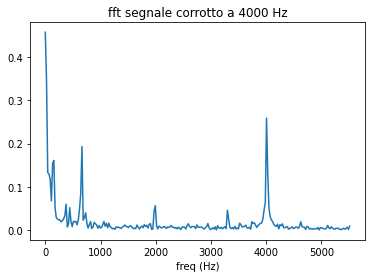

In [51]:
a = np.abs(np.fft.fft(xc))
a = a[0:len(a)//2]*2/a.shape[0]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale corrotto a 4000 Hz");

In [42]:
print(np.abs((100*xc).astype(int)).max())

126


# SALVATAGGIO FILE SPEZZATI

In [44]:
k_data = 100
k_coeff = 467

y = np.hstack((np.zeros(7), xc, np.zeros(10))) # 10 zeri di pulizia alla fine, 7 all'inizio (ad ogni numero servono 7 partner, creo i 7 partner del primo valore ecc.)

with open("input.txt","w") as fh :
    np.savetxt(fh, (y*k_data).astype(int), fmt="%d")

# LETTURA FPGA

**Che fine fa il k_coeff?** Probabilmente si perde nella approssimazione di prendere solo tot bit; questa stessa approssimazione forse può spiegare perché serva un fattore di 1.1 per rendere z perfettamente uguale alla simulazione. C'è comunque da dire che questi aggiustamenti di scala non modificano la forma relativa dei picchi nel segnale di z, cosa che suggerisce che comunque tutto sommato il filtro nella fpga funzioni!

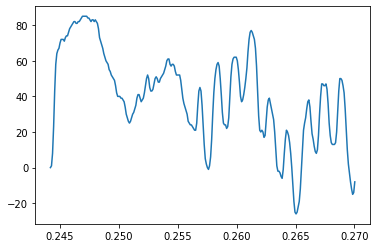

In [16]:
# SALTA FUORI CHE NON C'è BISOGNO DI BUTTARE I NUMERI FINALI!

z = np.loadtxt("fpga19_15-9_7_incompleto.txt")
#z = z[8:-10]
#z = z[7:-10]#/(k_coeff) # butto i primi 7 e gli ultimi 10
#z = z[7+4:-10]
z = z[7+5:] # truccato in modo che ci sia un solo 0 iniziale visto che quello simulato inizia con 0.2 qualcosa e poi sale a 2. qualcosa
#plt.plot(t2,z);
plt.plot(t2[:z.shape[0]],z);

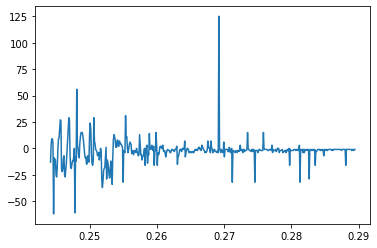

In [97]:
z = np.loadtxt("fpga_brutto.txt")
z = z[7:-10]#/(k_coeff) # butto i primi 7 e gli ultimi 10
plt.plot(t2,z);

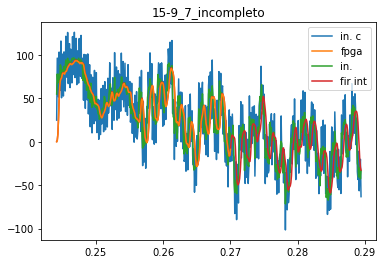

In [17]:
k_data = 100
k_coeff = 467

@njit
def fir_int(input, coeffs_int, Nt) :
    output_int = np.zeros(input.shape[0])
    for n in range(7, len(output_int)) :
        for i in range(Nt) :
            output_int[n] += int(coeffs_int[i]*input[n-i])
    return output_int


@njit
def fir_float(input, coeffs, Nt) :
    output_float = np.zeros(input.shape[0])
    for n in range(7, len(output_float)) :
        for i in range(Nt) :
            output_float[n] += coeffs[i]*input[n-i]
    return output_float

fs = 11025
fc = 1500 - 500 # meglio scendere un po', ma occhio ad essere troppo aggressivo sulla regione intorno a 5000 Hz
N_taps = 8
N = N_taps
coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")
coeffs_int = (k_coeff*coeffs).astype(int)
y_int = np.hstack((np.zeros((7,)),k_data*xc)).astype(int) # 7 è N-1

output_int = fir_int(y_int, coeffs_int, N)

output_int = output_int[7:] # tolgo i primi 7 valori fasulli

output_int /= k_coeff
#output_int /= k_data
#print(output_int)

y_float = np.hstack((np.zeros((7,)),k_data*xc))
output_float = fir_float(y_float, coeffs, N)
output_float = output_float[7:]
#output_float /= k_data
#print(output_float)

plt.plot(t2,k_data*xc, label="in. c",zorder=1);
plt.plot(t2[:z.shape[0]],z*(2**9/k_coeff),label="fpga",zorder=4);
plt.plot(t2,x2*k_data,label="in.",zorder=2);
#plt.plot(t2,output_float,label="fir",zorder=2);
plt.plot(t2,output_int,label="fir int",zorder=3);
plt.legend(loc="upper right");
plt.title("15-9_7_incompleto");

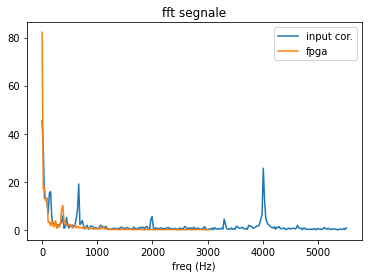

In [154]:
ac = np.abs(np.fft.fft((k_data*xc).astype(int)))
ac = ac[0:len(ac)//2]*2/ac.shape[0]
f = np.linspace(0,11025//2,len(ac))

az = np.abs(np.fft.fft(z))
az = az[0:len(az)//2]*2/az.shape[0]
#f = np.linspace(0,11025//2,len(a))
plt.plot(f,ac, label="input cor.");
plt.plot(f[0:len(az)],az, label="fpga");
plt.legend(loc="upper right")
plt.xlabel("freq (Hz)");
plt.title("fft segnale");

In [134]:
ac[:10]

array([45.404     , 34.36867508, 13.19950197, 12.9466536 , 11.66376488,
        6.72730841, 15.29450852, 15.97820379,  5.06890536,  2.83234244])

In [93]:
coeffs_int

array([  4,  23,  76, 127, 127,  76,  23,   4])

In [124]:
z[:10]

array([ 0.,  1.,  8., 23., 43., 58., 64., 66., 67., 70.])

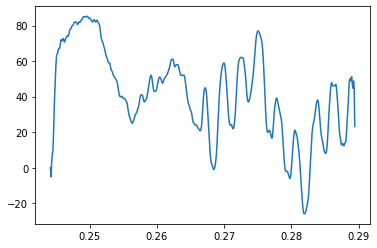

In [151]:
from scipy.signal import resample

z2 = resample(z, len(xc))
plt.plot(t2,z2);

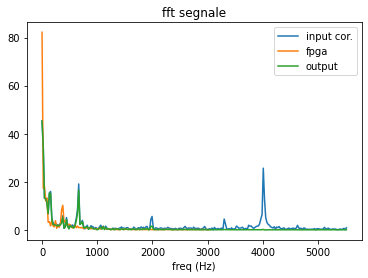

In [159]:
az2 = np.abs(np.fft.fft(z2))
az2 = az2[0:len(az2)//2]*2/az2.shape[0]
#f = np.linspace(0,11025//2,len(a))
plt.plot(f,ac, label="input cor.");
plt.plot(f[0:len(az)],az, label="fpga");
#plt.legend(loc="upper right")
plt.xlabel("freq (Hz)");
plt.title("fft segnale");

ao = np.abs(np.fft.fft(output_int))
ao = ao[0:len(ao)//2]*2/ao.shape[0]
plt.plot(f, ao, label="output");
plt.legend(loc="upper right")

In [157]:
t2[z.shape[0]]

0.269211588157954

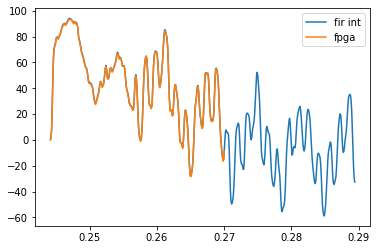

In [18]:
plt.plot(t2,output_int, label="fir int");
#plt.plot(t2[:z.shape[0]], 1.1*z, label="fpga");
plt.plot(t2[:z.shape[0]], (2**9/k_coeff)*z, label="fpga");
plt.legend(loc="upper right");

In [164]:
print(1.1*z[:10])
print(output_int[:10])

[ 0.   1.1  8.8 25.3 47.3 63.8 70.4 72.6 73.7 77. ]
[ 0.20556745  2.00428266  9.25910064 26.18201285 47.90792291 63.73447537
 70.77087794 72.72162741 74.52248394 77.57601713]


In [168]:
(coeffs*2**8).astype(int)

array([ 2, 13, 42, 70, 70, 42, 13,  2])

In [169]:
coeffs_int

array([  4,  23,  76, 127, 127,  76,  23,   4])

In [171]:
2**9 / k_coeff # tenendo i bit dal 15 al 9 sto ammazzando i bit da 8 a 0, cioè sto facendo uno shift right di 9 bits, cioè sto dividendo per 2**9, che non è esattamente k_coeff ma ci si avvicina. 
# ecco perché (posto che evidentemente il fir filter sulla fpga funziona) non devo dividere per k_coeff ma solo moltiplicare per 1.1; questo numero è infatti 2**9/k_coeff, cosa che (visto che z è output/2**9) evidentemente restituisce output/k_coeff (cioè quello che volevo fin dall'inizio)

1.0963597430406853

In [188]:
z3 = z*2**9/k_coeff 
l = np.abs((z3 - output_int[:z3.shape[0]])/output_int[:z3.shape[0]]).mean()
#l = np.abs((z3 - output_int[:z3.shape[0]])/z3).mean() # così ci sono divisioni per zero, ci vorrebbe una maschera logica
print(f"lo scarto relativo medio fra la simulazione e l'output della fpga è del {100*l}%")

lo scarto relativo medio fra la simulazione e l'output della fpga è del 7.33105184967113%


In [178]:
#print(z3[:10])
#print(output_int[:10])
print(np.abs(z3[:10]-output_int[:10]))

[0.20556745 0.90792291 0.4882227  0.96573876 0.76445396 0.14561028
 0.60385439 0.36188437 1.06638116 0.83083512]


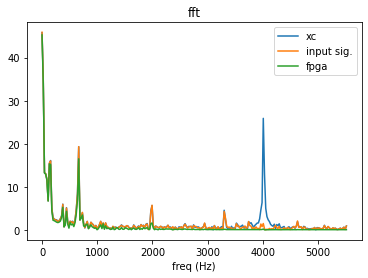

In [195]:
# supponendo allora che la differenza fra fpga e output_int sia trascurabile possiamo confrontare lo spettro di xc, x2 e output_int confondendo quest'ultimo con lo spettro che otterremmo se la porta seriale funzionasse sempre
ac = np.abs(np.fft.fft(xc*k_data)) # vedi commento qui sotto
ac = ac[0:len(ac)//2]*2/ac.shape[0]
f = np.linspace(0,11025//2,len(ac))
plt.plot(f,ac,label="xc");
plt.xlabel("freq (Hz)");
plt.title("fft");

az = np.abs(np.fft.fft(x2*k_data)) # occhio: devi usare la stessa scala per confrontare con i dati originali!!
az = az[0:len(az)//2]*2/az.shape[0]
#f2 = np.linspace(0,11025//2,len(a2))
plt.plot(f,az,label="input sig.");
#plt.xlabel("freq (Hz)");

ao = np.abs(np.fft.fft(output_int))
ao = ao[0:len(ao)//2]*2/ao.shape[0]
#f = np.linspace(0,11025//2,len(ao))
plt.plot(f,ao,label="fpga");
plt.xlabel("freq (Hz)");

plt.legend(loc="upper right");

# qui si apprezza come essere molto aggressivi con la frequenza di cutoff renda efficace la rimozione delle armoniche elevate ma produca proprio un appiattimento eccessivo delle componenti ad alta frequenza presenti nel segnale iniziale; questo però è un compromesso accettabile, perché queste armoniche davano un contributo trascurabile nel segnale iniziale. (le uniche armoniche non banali che si perdono sono quelle a 2000 e a ~ 3000 Hz, ma contano pur sempre meno della metà della armonica sotto i 1000 Hz)
# Questa discussione si può fare già confrontando la risposta spettrale in decibel dei vari fir filter

# Nota: il segnale che abbiamo è troppo corto (tipo 0.2 secondi) per potere giudicare quanto siano importanti quelle armoniche lì; siccome non abbiamo altri criteri "quantitativi" per giudicare la questione diciamo che c'è questo compromesso e basta (altrimenti dovrei rifare tutto con altri coefficienti del fir e non c'è garanzia che quegli stessi bit vadano bene e quindi se la porta seriale spesso muore è inutile pensare di fare confronti più approfonditi).

In [12]:
output_int.shape[0]

500

In [26]:
stride = 32
v1 = x2[z.shape[0]:]
print(v1.shape[0])

for j,i in enumerate(range(0,len(v1)-stride,stride)) :
    y = np.hstack((np.zeros(8),v1[i:i+stride],np.zeros(8)))
    np.savetxt(f"./in/input{j}.txt", (k_data*y).astype(int), fmt="%d")
    # with open(f"./in/input{j}.txt","w") as fh :
    #     for n in y :
    #         fh.write(str(int(n))+"\n")

224


In [20]:
224/32

7.0

# Output mancanti riempiti

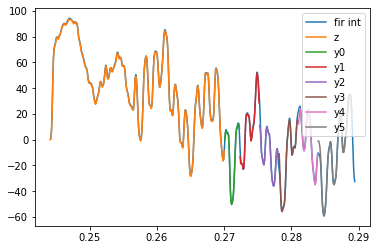

In [77]:
y0 = np.loadtxt("output/output0.txt")
y0 = y0[23:]
K = 2**9/k_coeff
zs = z.shape[0]
y0s = y0.shape[0]
#y0.shape[0]

y1 = np.loadtxt("output/output1.txt")
y1 = y1[16:]
y1s = y1.shape[0]

y2 = np.loadtxt("output/output2.txt")
y2 = y2[16:]
y2s = y2.shape[0]

y3 = np.loadtxt("output/output3.txt")
y3 = y3[16:] # probabilmente è 16 in riferimento agli 8 zero aggiunti alla fine del file precedente (che puliscono la pipeline) + gli 8 zeri inutili che ho messo all'inizio di questo file
y3s = y3.shape[0]

y4 = np.loadtxt("output/output4.txt")
y4 = y4[16:]
y4s = y4.shape[0]

y5 = np.loadtxt("outputf.txt")
u = 5
y5 = y5[u:]

s = np.cumsum([zs,y0s,y1s,y2s,y3s,y4s])

plt.plot(t2,output_int,label="fir int")
plt.plot(t2[:s[0]],z*K,label="z")
plt.plot(t2[s[0]:s[1]],y0*K,label="y0")
plt.plot(t2[s[1]:s[2]],y1*K,label="y1")
plt.plot(t2[s[2]:s[3]],y2*K,label="y2")
plt.plot(t2[s[3]:s[4]],y3*K,label="y3")
plt.plot(t2[s[4]:s[5]],y4*K,label="y4")
plt.plot(t2[s[5]:-u],y5*K,label="y5")

plt.legend(loc="upper right");

In [42]:
t2[s[4]:].shape[0]

93

In [46]:
s[4]+y4s

439

In [48]:
x2.shape[0] - 439

61

In [52]:
np.count_nonzero(np.loadtxt("output/output1.txt") == 0)

13

In [62]:
np.savetxt("inputf.txt", (xc[439:]*k_data).astype(int), fmt="%d")

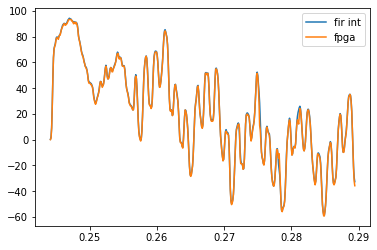

In [103]:
q = y5
q[:6] = output_int[s[5]:s[5]+6] # il picco all'inizio di y5
p = output_int[-5:]
yf = np.hstack((z,y0,y1,y2,y3,y4,q,p))
plt.plot(t2,output_int,label="fir int")
plt.plot(t2[:yf.shape[0]],yf*K,label="fpga")
plt.legend(loc="upper right");

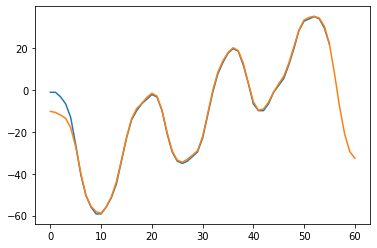

In [88]:
plt.plot(y5*K);
plt.plot(output_int[s[5]:])

In [95]:
np.nonzero(np.abs(y5*K - output_int[s[5]:s[5]+y5.shape[0]]) > 2) # solo i primi 5 valori sono spiritosi

(array([0, 1, 2, 3, 4], dtype=int64),)

In [104]:
np.savetxt("fpga_output_definitivo.txt", yf.astype(int), fmt="%d")

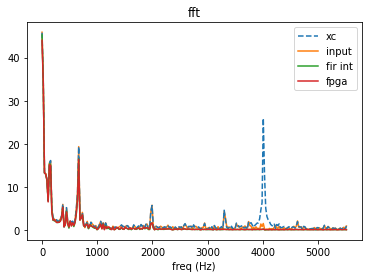

In [117]:
ac = np.abs(np.fft.fft(xc*k_data))
ac = ac[0:len(ac)//2]*2/ac.shape[0]
f = np.linspace(0,11025//2,len(ac))

ax = np.abs(np.fft.fft(x2*k_data))
ax = ax[0:len(ax)//2]*2/ax.shape[0]

ao = np.abs(np.fft.fft(output_int))/len(output_int)
ao = 2*ao[0:len(ao)//2]

af = np.abs(np.fft.fft(yf*K))/len(yf)
af = 2*af[0:len(af)//2]

plt.plot(f,ac,"--",label="xc",zorder=2)
plt.plot(f,ax,label="input",zorder=1)
plt.plot(f,ao,label="fir int",zorder=3)
plt.plot(f,af,label="fpga",zorder=4)

plt.xlabel("freq (Hz)")
plt.title("fft")
plt.legend(loc="upper right");